In [1]:
import numpy as np
import matplotlib.pyplot as plt

gamma = 0.99
alpha = 0.2

In [ ]:
Q = np.load("Q.npy")
C = np.load("C.npy")

### Original implementation of Monte-Carlo method

In [ ]:
def getGreedyPolicy(Q):
    return np.argmax(Q,axis=-1)

def innerMCControl(episode, Q, C, t_policy, getBPolicy):
    b_policy = getBPolicy(Q)
    G = 0.0
    W = 1.0
    converged = True
    step = len(episode)-1
    for state, action, reward in reversed(episode):
        G = gamma*G + reward
        C[state][action] += W
        q = Q[state][action]
        Q[state][action] += W/C[state][action] * (G-Q[state][action])
        converged = converged and abs(q - Q[state][action]) < CONVERGENCE_ERROR
        t_policy[state] = np.argmax(Q[state])
        if t_policy[state] != action: break
        W *= 1.0/b_policy[state][action]
        step -= 1
    
    print("\repisode length:{:7}; steps used:{:3}".format(len(episode),len(episode)-step), 
          end='', flush=True)
    return converged

In [ ]:
def MCControl(episodes,C,getBPolicy,QShape):
    C = np.zeros(dtype=np.float, shape=episodes.QShape)
    t_policy = getGreedyPolicy(episodes.Q)
    for episode in episodes:
        innerMCControl(episode, episodes.Q, C, t_policy, lambda Q: episodes.policy)

### Implementation of RaceTrack environment

In [2]:
MAX_VELOCITY = 4
MIN_VELOCITY = 0
TRACK_TAG = 1

## Track grid dimensions are [bottom-to-top, left-to-right]
## legend: [start, length, repeat]
## start: column, where track cells start;
## length: number of adjacent cells of track in the row, starting at `start`
## repeat: number of adjacent rows of the same shape, described by `start` and `length`
RT_grid = [3,6,3,
           2,7,7,
           1,8,8,
           0,9,7,
           0,10,1,
           0,17,2,
           1,16,1,
           2,15,2,
           3,14,1]
START_TAG = 2
start_line = (0,3,1,9)
FINISH_TAG = 3
finish_line = (26,16,32,17)
track_data = np.array(RT_grid).reshape((-1,3))
REWARD = -1
CONVERGENCE_ERROR = 0.02
ACCELERATION =  [[1,-1],  [1,0],  [1,1],
                 [0,-1],  [0,0],  [0,1],
                [-1,-1], [-1,0], [-1,1]]
ACTIONS_NUM = len(ACCELERATION)

### Building race track ###
# Determine extents of race track grid.
track = np.zeros(shape=(np.sum(track_data[:,-1]), 
                        max(np.sum(track_data[:,:-1], axis=1))),
                dtype = np.uint8)
print(track.shape)
row=0
# Fill the race track grid with designed designation marks
for start,length,repeat in track_data:
    for i in range(repeat):
        track[row, start:start+length] = TRACK_TAG
        row += 1
track[start_line[0]:start_line[2],start_line[1]:start_line[3]] = START_TAG
track[finish_line[0]:finish_line[2],finish_line[1]:finish_line[3]] = FINISH_TAG

(32, 17)


In [3]:
def rt_getStartPosition():
    return (0,np.random.randint(start_line[1], start_line[3]),0,0)

def rt_getTransition(track, state, action, getStartPosition=rt_getStartPosition):
    #next_velocity = np.vectorize(lambda x: min(x,MAX_VELOCITY))(state[1]+action)
    accel = ACCELERATION[action]
    next_velocity = np.clip([state[2]+accel[0],state[3]+accel[1]], 
                            MIN_VELOCITY, MAX_VELOCITY)
    if (next_velocity == [0,0]).all():
        next_velocity = [state[2],state[3]]
    position = [state[0],state[1]]
    next_position = position + next_velocity
    disp = next_velocity
    #intersection_row = (disp[0]/disp[1]) * (track.shape[1]-position[1]) + position[0]
    is_finished = next_position[1] >= track.shape[1] and \
        26.0 <= (disp[0]/disp[1]) * (track.shape[1]-position[1]) + position[0] < 32.0
    
    if is_finished: return (True,getStartPosition())
    
    next_position = tuple(next_position)
    if next_position in np.ndindex(track.shape) and \
        track[next_position] > 0:
        next_state = next_position + tuple(next_velocity)
    else:
        next_state = getStartPosition()
        
    return (False,next_state)

### Original implementation of ε-greedy policy (for history)

In [ ]:
def getBPolicy(Q, epsilon):
    eps_policy = np.ones(dtype=np.float, shape=Q.shape) * epsilon/ACTIONS_NUM
    for state in np.ndindex(Q.shape[:-1]):
        action = np.argmax(Q[state])
        eps_policy[state][action] += 1.0-epsilon
    return eps_policy

def getBPolicyLog(Q, epsilon, step):
    e = min(1.0, epsilon/np.log(max(2,step/100)))
    eps_policy = np.ones(dtype=np.float, shape=Q.shape) * e/ACTIONS_NUM
    for state in np.ndindex(Q.shape[:-1]):
        action = np.argmax(Q[state])
        eps_policy[state][action] += 1.0-e
    return eps_policy


disp[1]/disp[0] == (track.shape[1]-position[1])/(track_row-position[0])
track_row = (disp[0]/disp[1]) * (track.shape[1]-position[1]) + position[0]

### Original implementation of sequence generator (for history)

In [ ]:
def getAction(policy, state):
    return (np.nonzero(np.random.multinomial(1, policy[state]))[0])[0]

def rt_generateEpisode(b_policy, getAction):
    state = rt_getStartPosition()
    episode = []
    while True:
        action = getAction(b_policy, state)
        episode.append((state, action, reward))
        is_finished, next_state = rt_getTransition(track, state, action)
        if is_finished: break
        state = next_state

    return episode



### Run Racetrack learning 

In [47]:
import sys
sys.path.append('..')
import SeqGen
import SARSAn

QShape = track.shape + (MAX_VELOCITY+1, MAX_VELOCITY+1, ACTIONS_NUM)
Q = np.zeros(QShape) #(np.random.random(QShape)-0.5)*0.1

In [64]:
sequence = SeqGen.SequenceGeneratorPlus(
                                SeqGen.EpsilonGreedyPolicy(Q, 0.05),
                                rt_getStartPosition,
                                lambda s,a: rt_getTransition(track, s, a) + (REWARD,),
                                10000
                               )

In [65]:
alpha = 0.03
def q_learn(s,a,v): 
    Q[s][a] = Q[s][a] + alpha*(v-Q[s][a])

SARSAn.SARSAn(sequence, 
              lambda s,a: Q[s][a], 
              q_learn,
              n=10,
              gamma=0.98
             )

Episode length is      12
Sequence terminated.

Finished.


### Original implementation of n-step SARSA (for history)

In [ ]:
# Loop for each episode:
for episode_i in range(50000):
    # Initialize and store S[0] != terminal
    # Select and store an action A[0] ~ π(·|S[0])
    step = next(sequence_iter)
    state, is_terminal, next_state, action, reward = step
    # T ← ∞
    T = sys.maxsize
    # Loop for t = 0, 1, 2, . . . :
    t = 0
    history = [step]

    while True:
        # If t < T , then:
        if t < T:
            # Take action A[t]
            # Observe and store the next reward as R[t+1] and the next state as S[t+1]
            # already done, when selected A[t]
            # If S[t+1] is terminal, then:
            if is_terminal:
            # T ← t+1
                T = t+1
                print("\rEpisode length is {:7}; tau={:7}".format(T,tau), end='', flush=True)
            # else:
            else:
                # Select and store an action A[t+1] ~ π(·|S[t+1])
                step = next(sequence_iter)
                # get S[t+1], is_term, S[t+2], A[t+1], R[t+2]
                state, is_terminal, next_state, action, next_reward = step
                history.append(step)

        # τ ← t-n+1 (τ is the time whose estimate is being updated)
        tau = t-n+1  # tau+n == t+1
        # If τ ≥ 0:
        if tau >= 0:
            # G ← Sum(i, τ+1, min(τ+n,T))(γ^(i-τ-1)*R[i])
            # min(τ+n,T) == min(n,T-τ) + τ
            # in the following i == j+τ+1; history[i] containes R[i+1]
            G = np.sum( [gamma_powered[j]*history[tau+j][REWARD_I] 
                         for j in range(0,min(n,T-tau))])
            # If τ + n < T , then G ← G + γ^n * Q(S[τ+n], A[τ+n])
            if tau+n < T:
                G = G + gamma_powered[n] * Q[state][action]
            # Q(S[τ], A[τ]) ← Q(S[τ], A[τ]) + α*[G - Q(S[τ], A[τ])]
            # If π is being learned, then ensure that π(·|S[τ]) is ε-greedy wrt Q
            Stau, istrm, next_tau, Atau, Rtau = history[tau]
            Q[Stau][Atau] = Q[Stau][Atau] + alpha*(G - Q[Stau][Atau])

        # Until τ = T-1
        if tau == T-1: break
        t += 1
print("\nFinished.")

In [ ]:
print(tau, t, T, len(history), is_terminal, state, ACCELERATION[action], next_state)


In [ ]:
print(Stau,Atau,G)
Q[Stau][Atau]

In [ ]:
for i in range(5):
    s0, is_terminal, state, action, reward = next(sequence_iter)
    print( s0, is_terminal, state, ACCELERATION[action], reward )

In [ ]:
np.save("Q-Sarsa-n",Q)

### Original implementation of episodes generator (for history)

In [ ]:
class Episodes:
    def __init__(self, N, Q, track, getBPolicy):
        self.samples_num = N
        self.state_shape = Q.shape[:-1]
        self.Q = Q
        self.getBPolicy = getBPolicy
    
    def __iter__(self):
        self.N = self.samples_num
        return self
    
    def __next__(self):
        if self.N == 0: raise StopIteration
        self.N -= 1
        self.policy = self.getBPolicy(self.Q, self.samples_num-self.N)
        return rt_generateEpisode(self.policy, getAction)

In [ ]:
def MC_run(N, Q, C):
    episodes = Episodes(N, Q, track, lambda q,s: getBPolicy(q,10000.0/(20000.0+s)))
                        #lambda q,s: rt_getBPolicy(q,0.5)) #lambda q,s: getBPolicyLog(q,0.7,s))
    t_policy = getGreedyPolicy(episodes.Q)
    conv_count = 0
    for episode in episodes:
        if innerMCControl(episode, episodes.Q, C, t_policy, lambda Q: episodes.policy):
            conv_count += 1
        else: 
            conv_count = 0
        if conv_count >= 500:
            print("\nConvergence reached.")
            break
            
    print("\nEpisodes generated: {}".format(episodes.samples_num - episodes.N))

### Run Monte-Carlo method on RaceTrack problem #1

In [ ]:
QShape = track.shape + (MAX_VELOCITY+1, MAX_VELOCITY+1, ACTIONS_NUM)
Q = (np.random.random(QShape)-0.5)*0.1 - 30.0
C = np.zeros(dtype=np.float, shape=Q.shape)
MC_run(40000, Q, C)

In [ ]:
MC_run(50000, Q, C)

In [ ]:
def buildEpisode(startPosition, policy):
    state = startPosition
    episode = []
    while True:
        action = policy[state]
        episode.append((state, action, reward))
        is_finished, next_state = rt_getTransition(track, state, action, lambda:startPosition)
        if is_finished or next_state==startPosition: break
        state = next_state
        
    return episode

def buildTrack(policy):
    return

In [ ]:
p = getGreedyPolicy(Q)
episode = buildEpisode((0,5,0,0),p)
last = episode[-1]
episode.append((tuple(np.array(last[0][:2])+np.array(last[0][2:])+ACCELERATION[last[1]]) +
               (0,0),0,len(episode)))

trace = np.array([list(s[:2]) for s,a,r in episode])
episode

### Plot the optimal paths

In [9]:
class ImmutableGreedyPolicy:
    def __init__(self, Q):
        self.action = np.argmax(Q,axis=-1);
        
    def __call__(self, state):
        return self.action[state]
    

In [66]:
epi = 3
def startPosition():
    global epi
    return (0,epi,0,0)


test_gen = SeqGen.SequenceGeneratorPlus(
    ImmutableGreedyPolicy(Q), 
    startPosition,
    lambda s,a: rt_getTransition(track, s, a, getStartPosition = lambda : (0,7,0,0)) + (REWARD,),
    episodes_max = 6,
    episode_maxlen = 20
    )

traces = []
episode = []
for state, is_terminal, next_state, action, reward in test_gen:
    episode.append(state[0:2])
    if is_terminal:
        traces.append(np.array(episode))
        episode = []
        epi += 1

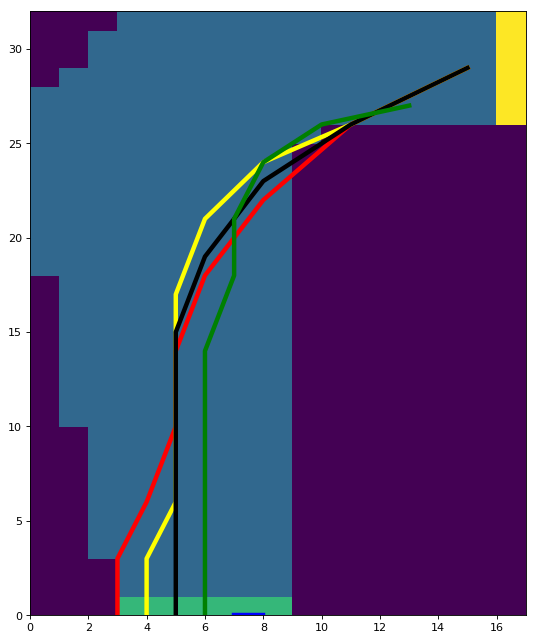

In [67]:
f = plt.figure(num=None, figsize=(8,10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(track, figure=f)
cols = ['red','yellow','black','green','white','blue']
i = 0
for trace in traces:
    plt.plot(trace[:,1], trace[:,0], figure=f, linewidth=4.0, color=cols[i])
    i += 1

In [ ]:
QShape = track.shape + (MAX_VELOCITY+1, MAX_VELOCITY+1, ACTIONS_NUM)
Q = (np.random.random(QShape)-0.5)*0.1 - 30.0
episodes = Episodes(200, Q, track, lambda q,s: getBPolicyLog(q,0.7,s))
C = np.zeros(dtype=np.float, shape=episodes.Q.shape)
t_policy = getGreedyPolicy(episodes.Q)
conv_count = 0
for episode in episodes:
    if innerMCControl(episode, episodes.Q, C, t_policy, lambda Q: episodes.policy):
        conv_count += 1
    else: 
        conv_count = 0
    if conv_count > 100:
        print("Convergence reached.")
print("\nEpisodes generated: {}".format(episodes.samples_num - episodes.N))

In [ ]:
episodes = Episodes(2000, episodes.Q, track, lambda Q,s: rt_getBPolicy(Q,s,0.5))
for episode in episodes:
    innerMCControl(episode, episodes.Q, C, t_policy, lambda Q: episodes.policy)

In [ ]:
def rt_getTargetPolicyAction(Q, state):
    return np.argmax(Q[state])

In [ ]:
np.save("Q",Q)
np.save("C",C)

In [ ]:
epsilon = 0.5
getBPolicy = lambda Q: rt_getBPolicy(Q,epsilon)
MCControl()

In [ ]:
f,ns = rt_getTransition(track,state,action)
print(f,ns)
[(ACCELERATION[a],rt_getTransition(track,ns,a)) for a in range(9)]